In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
# Load backtest results
file_path = 'backtest_results.csv'  # Update with your actual file path
data = pd.read_csv(file_path)

# Ensure datetime format if there's a timestamp column
if 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Num', inplace=True)

data.drop(columns=['Swap', 'Symbol', 'Order', 'Unnamed: 0'], inplace=True)

# Inspect the data
data.head()

,Date,Type,Direction,Volume,Price,Commission,Profit,Balance,Comment
Num,,,,,,,,,
1,2023-01-03 01:00:39,buy,in,0.96,1 828.67,- 2.88,0.00,99 997.12,NaN
2,2023-01-03 13:00:02,sell,out,0.96,1 834.42,0.00,552.00,100 549.12,NaN
3,2023-01-03 15:17:31,buy,in,1.31,1 838.97,- 3.93,0.00,100 545.19,NaN
4,2023-01-03 17:28:39,sell,out,1.31,1 832.77,0.00,- 812.20,99 732.99,sl 1832.77
5,2023-01-03 17:28:44,buy,in,26.64,1 833.00,- 79.92,0.00,99 653.07,NaN


In [33]:
# Load the CSV file
df = pd.read_csv('fixed.csv', delimiter=',', skipinitialspace=True)

# Clean numeric columns (remove spaces and convert to float)
numeric_cols = ['Price', 'Commission', 'Profit', 'Balance']
for col in numeric_cols:
    df[col] = df[col].str.replace(' ', '').astype(float)
    
# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Num,Date,Type,Direction,Volume,Price,Commission,Profit,Balance,Comment
0,1,2023-01-03 01:00:39,buy,in,0.96,1828.67,-2.88,0.0,99997.12,NaN
1,2,2023-01-03 13:00:02,sell,out,0.96,1834.42,0.00,552.0,100549.12,NaN
2,3,2023-01-03 15:17:31,buy,in,1.31,1838.97,-3.93,0.0,100545.19,NaN
3,4,2023-01-03 17:28:39,sell,out,1.31,1832.77,0.00,-812.2,99732.99,sl 1832.77
4,5,2023-01-03 17:28:44,buy,in,26.64,1833.00,-79.92,0.0,99653.07,NaN


Pair Entry and Exit Trades

In [47]:
trades = []

# Iterate through pairs of rows (entry 'in' and exit 'out')
for i in range(0, len(df)-1, 2):
    entry = df.iloc[i]
    exit = df.iloc[i+1]
    
    if entry['Direction'] == 'in' and exit['Direction'] == 'out':
        trade = {
            'EntryDate': entry['Date'],
            'ExitDate': exit['Date'],
            'Type': entry['Type'],
            'Volume': entry['Volume'],
            'EntryPrice': entry['Price'],
            'ExitPrice': exit['Price'],
            'Profit': exit['Profit'],
            'StopLoss': 'sl' in str(exit['Comment']).lower(),
            'Duration': (exit['Date'] - entry['Date']).total_seconds() / 60  # in minutes
        }
        trades.append(trade)

trades_df = pd.DataFrame(trades)

Feature Engineering

In [48]:
# Extract time-based features
trades_df['EntryHour'] = trades_df['EntryDate'].dt.hour
trades_df['EntryDay'] = trades_df['EntryDate'].dt.day_name()

# Calculate price change percentage
trades_df['PriceChangePct'] = (trades_df['ExitPrice'] - trades_df['EntryPrice']) / trades_df['EntryPrice'] * 100

trades_df['ReturnPct'] = trades_df['Profit'] / (trades_df['Volume'] * trades_df['EntryPrice'])

trades_df.head()

,EntryDate,ExitDate,Type,Volume,EntryPrice,ExitPrice,Profit,StopLoss,Duration,EntryHour,EntryDay,PriceChangePct,ReturnPct
0,2023-01-03 01:00:39,2023-01-03 13:00:02,buy,0.96,1828.67,1834.42,552.00,False,719.383333,1,Tuesday,0.314436,0.314436
1,2023-01-03 15:17:31,2023-01-03 17:28:39,buy,1.31,1838.97,1832.77,-812.20,True,131.133333,15,Tuesday,-0.337145,-0.337145
2,2023-01-03 17:28:44,2023-01-03 17:30:29,buy,26.64,1833.00,1832.64,-959.04,True,1.750000,17,Tuesday,-0.019640,-0.019640
3,2023-01-03 22:55:02,2023-01-04 02:00:00,buy,2.31,1838.35,1836.45,-438.90,False,184.966667,22,Tuesday,-0.103354,-0.103354
4,2023-01-04 03:16:37,2023-01-04 17:15:00,buy,2.25,1839.48,1850.17,2405.25,False,838.383333,3,Wednesday,0.581142,0.581142


Analyze Losing vs Winning Trades

In [ ]:
# Separate losing and winning trades
losing = trades_df[trades_df['Profit'] < 0]
winning = trades_df[trades_df['Profit'] >= 0]

# Pattern 1: Time of Day Analysis
print("Losing Trades by Hour:")
print(losing['EntryHour'].value_counts().sort_index())

# Pattern 2: Stop Loss Impact
print(f"% of Losing Trades with Stop Loss: {losing['StopLoss'].mean() * 100:.1f}%")

# Pattern 3: Trade Duration
print(f"Avg Duration (Losing): {losing['Duration'].mean():.1f} minutes")
print(f"Avg Duration (Winning): {winning['Duration'].mean():.1f} minutes")

# Pattern 4: Trade Type Analysis
print("Losing Trades by Type:")
print(losing['Type'].value_counts())

% of Losing Trades with Stop Loss: 58.6%
Avg Duration (Losing): 141.3 minutes
Avg Duration (Winning): 1453.5 minutes
Losing Trades by Type:
Type
buy     596
sell    469
Name: count, dtype: int64


Visualize Key Metrics

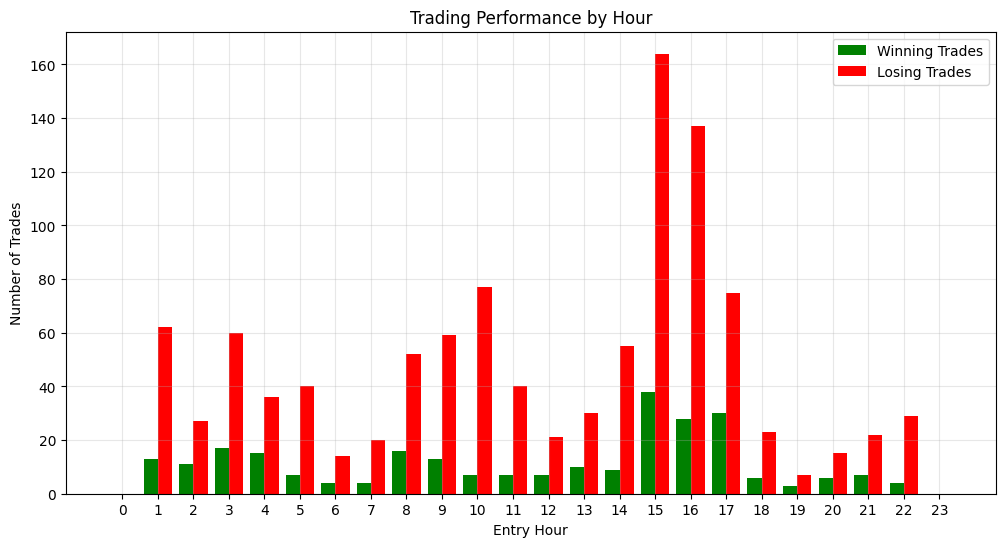

/tmp/ipykernel_34673/1026293181.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=np.where(trades_df['Profit'] >= 0, 'Winning', 'Losing'),


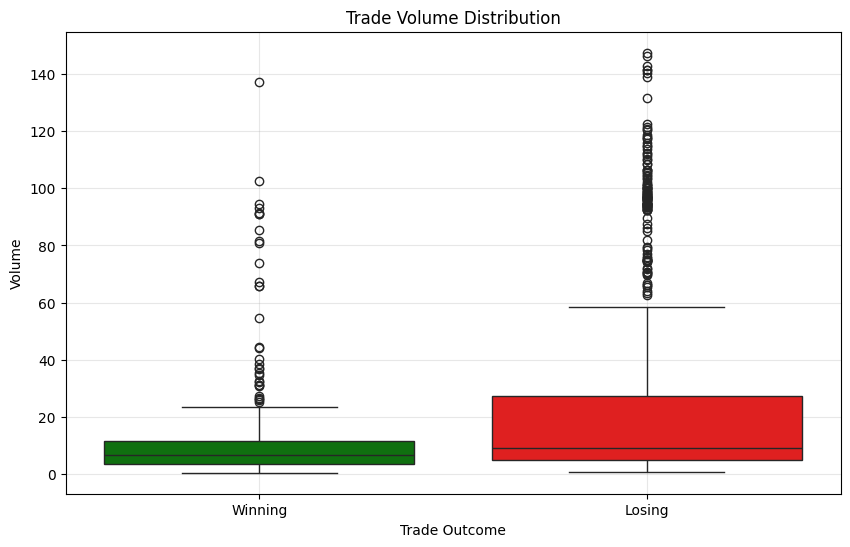

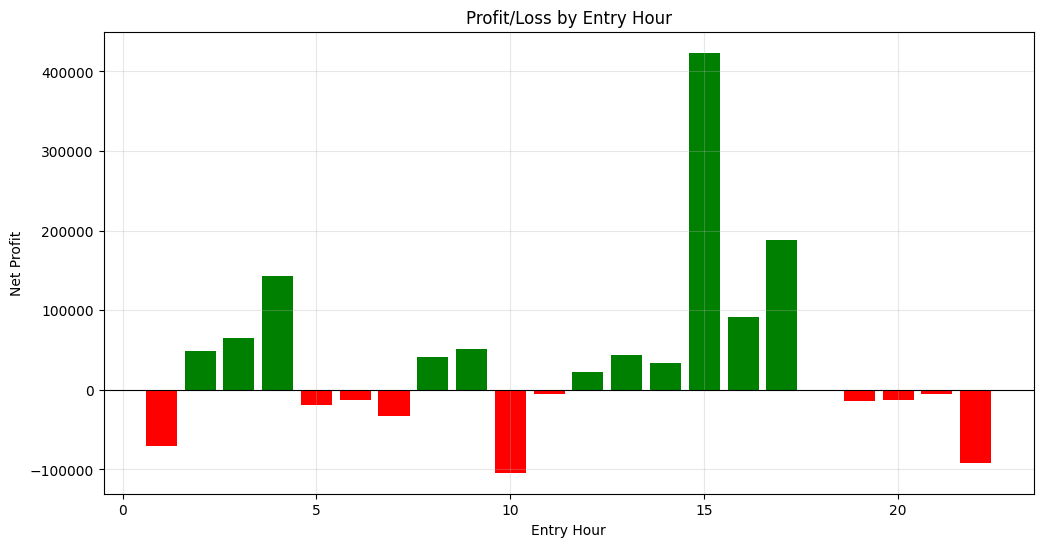

In [50]:
# 1. Combined Win/Loss by Hour Plot
plt.figure(figsize=(12, 6))
all_hours = pd.Series(range(24))
winning_hours = trades_df[trades_df['Profit'] >= 0]['EntryHour'].value_counts().reindex(all_hours, fill_value=0)
losing_hours = trades_df[trades_df['Profit'] < 0]['EntryHour'].value_counts().reindex(all_hours, fill_value=0)

plt.bar(all_hours - 0.2, winning_hours, width=0.4, label='Winning Trades', color='green')
plt.bar(all_hours + 0.2, losing_hours, width=0.4, label='Losing Trades', color='red')
plt.title('Trading Performance by Hour')
plt.xlabel('Entry Hour')
plt.ylabel('Number of Trades')
plt.legend()
plt.xticks(range(24))
plt.grid(True, alpha=0.3)
plt.show()

# 2. Volume Comparison Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=np.where(trades_df['Profit'] >= 0, 'Winning', 'Losing'),
            y=trades_df['Volume'],
            palette=['green', 'red'])
plt.title('Trade Volume Distribution')
plt.xlabel('Trade Outcome')
plt.ylabel('Volume')
plt.grid(True, alpha=0.3)
plt.show()

# 3. P&L by Hour Plot
plt.figure(figsize=(12, 6))
hourly_pnl = trades_df.groupby('EntryHour')['Profit'].sum()
plt.bar(hourly_pnl.index, hourly_pnl.values, color=np.where(hourly_pnl >= 0, 'green', 'red'))
plt.title('Profit/Loss by Entry Hour')
plt.xlabel('Entry Hour')
plt.ylabel('Net Profit')
plt.grid(True, alpha=0.3)
plt.axhline(0, color='black', linewidth=0.8)
plt.show()